Using device: cuda


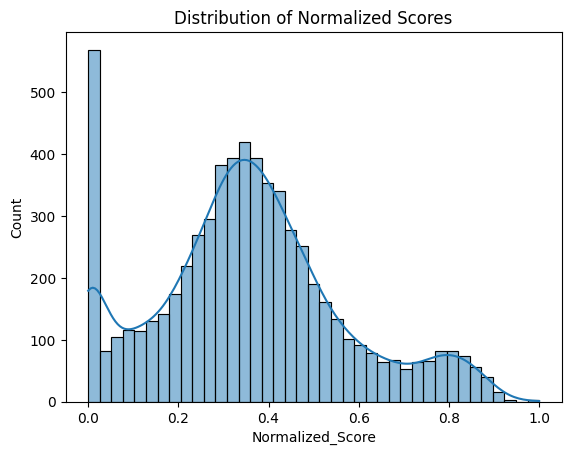

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Start Training...


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.19it/s]


Epoch 1/20, Training Loss: 0.0461, Validation Loss: 0.0549


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.22it/s]


Epoch 2/20, Training Loss: 0.0388, Validation Loss: 0.0662


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s]

Epoch 3/20, Training Loss: 0.0362, Validation Loss: 0.0698


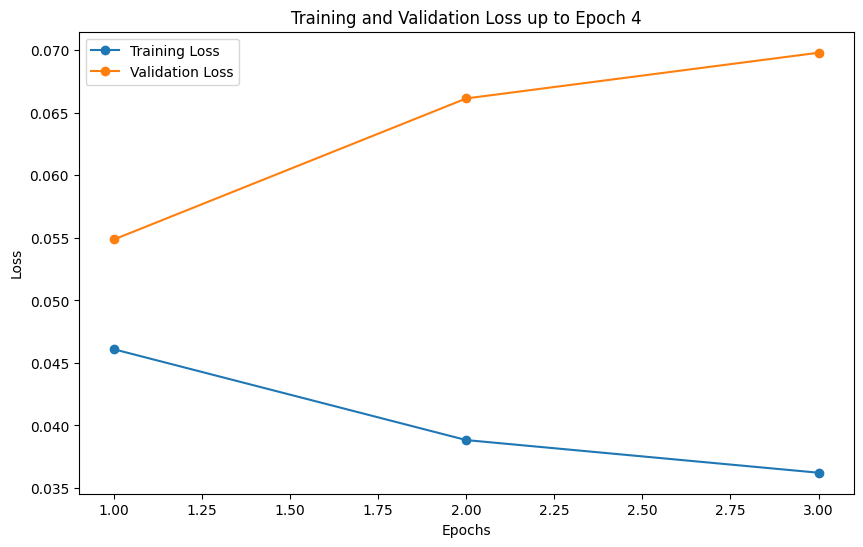

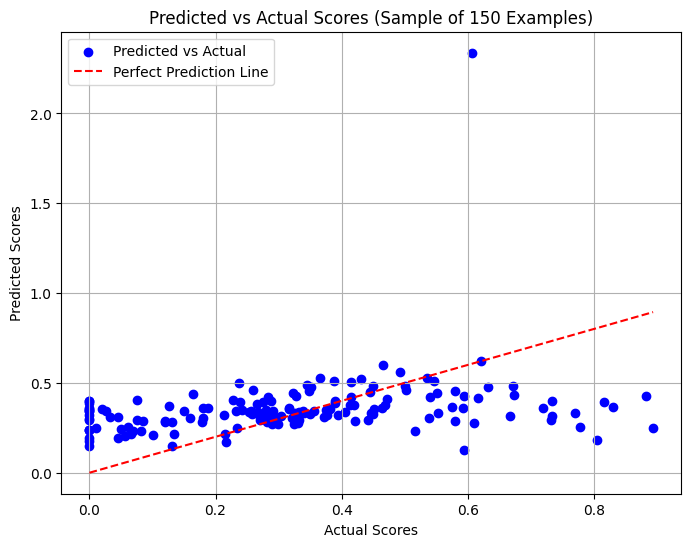

Model weights saved successfully!


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.20it/s]


Epoch 4/20, Training Loss: 0.0333, Validation Loss: 0.0456


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s]


Epoch 5/20, Training Loss: 0.0312, Validation Loss: 0.0486


Validation Progress: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s]


Epoch 6/20, Training Loss: 0.0279, Validation Loss: 0.0524


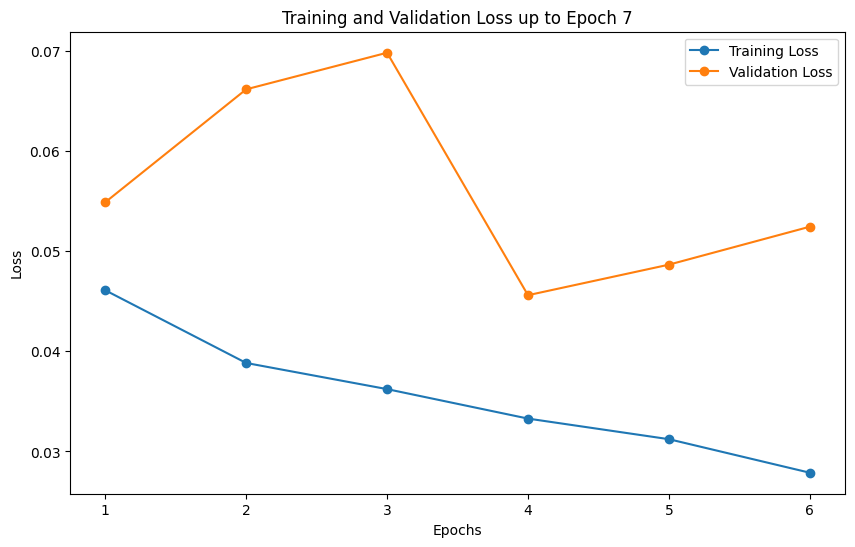

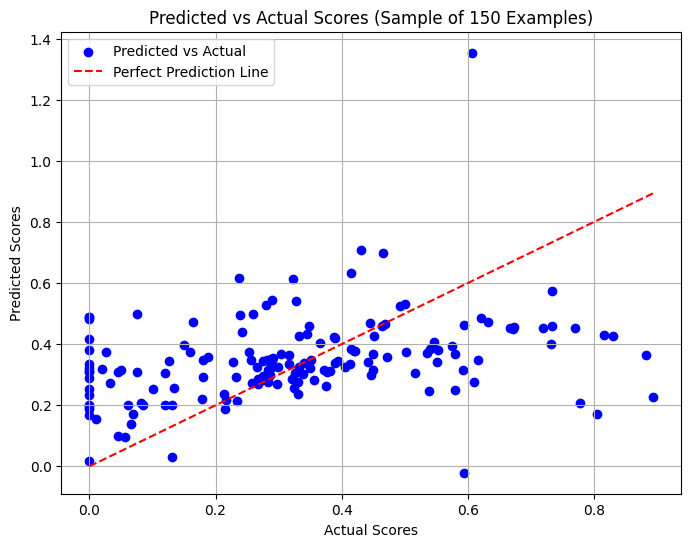

Model weights saved successfully!


Validation Progress: 100%|██████████| 81/81 [00:35<00:00,  2.25it/s]


Epoch 7/20, Training Loss: 0.0245, Validation Loss: 0.0639


Validation Progress: 100%|██████████| 81/81 [00:37<00:00,  2.17it/s]


Epoch 8/20, Training Loss: 0.0218, Validation Loss: 0.0529


Validation Progress: 100%|██████████| 81/81 [00:35<00:00,  2.27it/s]

Epoch 9/20, Training Loss: 0.0188, Validation Loss: 0.0640
Early stopping triggered after 9 epochs.


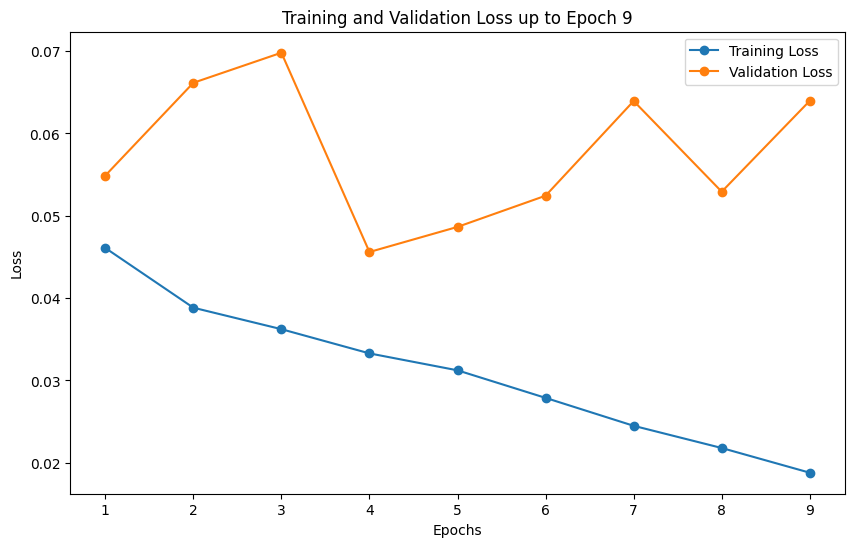

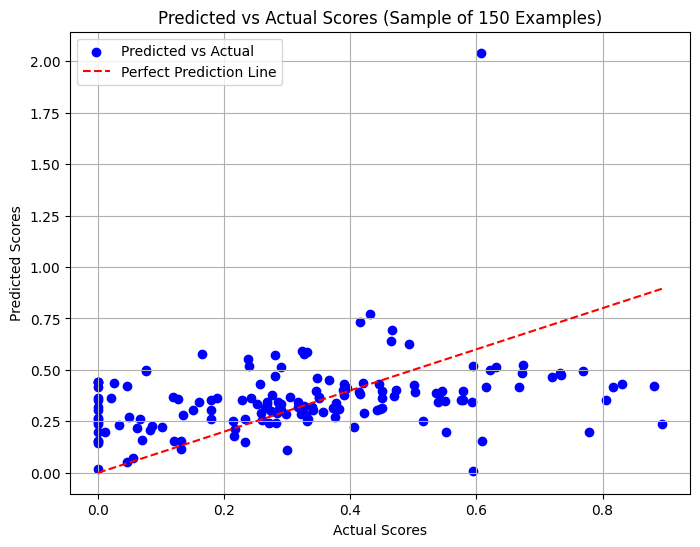

Model weights saved successfully!


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
import sys
sys.path.append('/kaggle/input/retrievalmodel/pytorch/default/1')

import spacy

import datasets
datasets.disable_progress_bar()

import logging
logging.getLogger("spacy").setLevel(logging.ERROR)
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

from tqdm import tqdm

# Dataset class to load and preprocess CSV data
class BusinessIdeaDataset(Dataset):
    def __init__(self, csv_file, max_length=512):
        self.csv_file = csv_file
        self.data = pd.read_csv(csv_file)
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Normalize the stock performance columns
        self.data['Historical'] = self.data['Historical'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        historical_prices = self.data['Historical'].apply(pd.Series)
        scaler = MinMaxScaler()
        normalized_prices = scaler.fit_transform(historical_prices)
        self.data['Normalized_Historical'] = normalized_prices.tolist()
        
        score_scaler = MinMaxScaler()
        self.data['Normalized_Score'] = score_scaler.fit_transform(self.data[['Score_2']])

        import seaborn as sns
        import matplotlib.pyplot as plt
        
        sns.histplot(self.data['Normalized_Score'], kde=True)
        plt.title("Distribution of Normalized Scores")
        plt.show()

        self.model_type = 'all-MiniLM-L6-v2'
        self.model = SentenceTransformer(self.model_type)
        self.model = self.model.to(self.device)
        self.nlp = spacy.load("en_core_web_sm")  # Load spaCy for preprocessing
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        idea = row['Idea']
        score_2 = torch.tensor(row['Normalized_Score'], dtype=torch.float).to(self.device)  # use score 2 because it has the best distribution in the given dataset
        stock_performance = torch.tensor(row['Normalized_Historical'], dtype=torch.float).to(self.device)
        
        # Tokenizing the idea text
        #bert_encodings = self.retrieval_system.encode(idea)
        bert_encodings = self.encode(idea)
        bert_encodings = torch.tensor(bert_encodings, dtype=torch.float).to(self.device)  # Move to GPU

        if torch.any(torch.isnan(bert_encodings)) or torch.any(torch.isnan(stock_performance)):
            print(f"NaN detected in data at index {idx}")
            return None  # Return None if the data is invalid
        
        return {
            'idea_encoding': bert_encodings,
            'stock_performance': stock_performance,  # Move to GPU
            'score': score_2
        }

    def encode(self, text: str):
        doc = self.nlp(text)
        # Remove stop words and punctuation, and apply lemmatization
        preprocessed_text = " ".join(
            [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        )
        return self.model.encode(preprocessed_text)

class EnhancedRankingModel(nn.Module):
    def __init__(self, encoding_dim=384, historical_dim=12, hidden_size=256, dropout_rate=0.1):
        """
        A neural network model for ranking business ideas based on textual encoding and historical stock data.
        """
        super(EnhancedRankingModel, self).__init__()
        
        # TODO
        # dimensions
        # 
        
        # Idea encoding branch
        self.idea_fc = nn.Sequential(
            nn.Linear(encoding_dim, hidden_size),
            nn.BatchNorm1d(hidden_size),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Historical stock data branch
        self.stock_fc = nn.Sequential(
            #nn.Linear(historical_dim, hidden_size), # TODO
            nn.BatchNorm1d(historical_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.attention = nn.MultiheadAttention(embed_dim= hidden_size + historical_dim, num_heads=2, batch_first=True)
        
        # Combined branch
        self.combined_fc = nn.Sequential(
            nn.Linear(hidden_size + historical_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), 1)
        )
        
    
    def forward(self, idea_encoding, stock_performance):
        """
        Forward pass through the model.
        """
        # Process idea encoding
        idea_features = self.idea_fc(idea_encoding)
        
        # Process historical stock performance
        stock_features = self.stock_fc(stock_performance)
        
        # Concatenate the features
        combined_features = torch.cat((idea_features, stock_features), dim=1)

        attention_output, _ = self.attention(combined_features.unsqueeze(1), 
                                         combined_features.unsqueeze(1), 
                                         combined_features.unsqueeze(1))
    
        # Remove the sequence dimension added by attention (squeeze dim=1)
        attention_output = attention_output.squeeze(1)
        # Compute the score
        score = self.combined_fc(attention_output)
        
        
        return score.squeeze()


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
dataset = BusinessIdeaDataset(
    csv_file='/kaggle/input/paddedentirefinaldataset/padded_entire_final_dataset.csv'
)

# Split indices into training (80%) and evaluation (20%)
train_indices, val_indices = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42  # For reproducibility
)

# Create subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Move the model to GPU
model = EnhancedRankingModel().to(device)

# Optimizer and loss function remain the same
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

loss_fn = nn.MSELoss()

import numpy as np
def evaluate_model(model, val_loader, device, amount_scores = 150):
    model.eval()
    
    # Store predicted and actual values
    predicted_scores = []
    actual_scores = []
    
    with torch.no_grad():
        for batch in val_loader:
            idea_encoding = batch['idea_encoding'].to(device)
            stock_performance = batch['stock_performance'].to(device)
            scores = batch['score'].to(device)

            pred_scores = model(idea_encoding, stock_performance)
            predicted_scores.extend(pred_scores.cpu().numpy())
            actual_scores.extend(scores.cpu().numpy())

            if len(predicted_scores) >= amount_scores:
                break
    
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_scores, predicted_scores, color='blue', label='Predicted vs Actual')
    
    plt.plot([min(actual_scores), max(actual_scores)], [min(actual_scores), max(actual_scores)], color='red', linestyle='--', label='Perfect Prediction Line')
    
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title(f'Predicted vs Actual Scores (Sample of {amount_scores} Examples)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_scores, actual_scores

# Training loop
epochs = 20
print('Start Training...')
training_losses = []
validation_losses = []
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

for epoch in range(epochs):
    if epoch != 0 and epoch % 3 == 0:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss", marker='o')
        plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss up to Epoch {epoch + 1}")
        plt.legend()
        plt.show()
        evaluate_model(model, val_loader, device)
        torch.save(model.state_dict(), "ranking_model_weights.pth")
        print("Model weights saved successfully!")

    # Training phase
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc="Training Progress"):
        idea_encoding = batch['idea_encoding'].to(device)
        stock_performance = batch['stock_performance'].to(device)
        scores = batch['score'].to(device)
        optimizer.zero_grad()
        predicted_scores = model(idea_encoding, stock_performance)
        loss = loss_fn(predicted_scores, scores)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation Progress"):
            idea_encoding = batch['idea_encoding'].to(device)
            stock_performance = batch['stock_performance'].to(device)
            scores = batch['score'].to(device)

            predicted_scores = model(idea_encoding, stock_performance)
            loss = loss_fn(predicted_scores, scores)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_ranking_model_weights.pth")  # Save the best model
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# Save the final model weights
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss up to Epoch {epoch + 1}")
plt.legend()
plt.show()
evaluate_model(model, val_loader, device)
torch.save(model.state_dict(), "ranking_model_weights.pth")
print("Model weights saved successfully!")

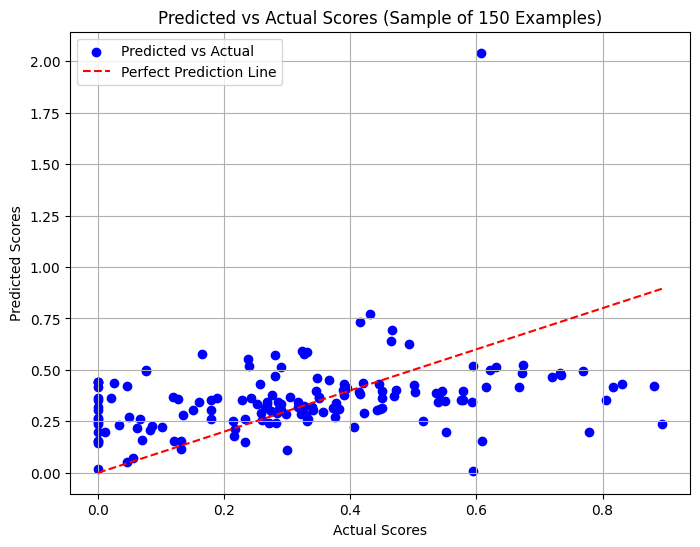

Predicted vs Actual Scores (160 Examples):
Example 1: Actual = 0.0106, Predicted = 0.2001
Example 2: Actual = 0.0659, Predicted = 0.2623
Example 3: Actual = 0.4053, Predicted = 0.2236
Example 4: Actual = 0.3272, Predicted = 0.5778
Example 5: Actual = 0.1649, Predicted = 0.5771
Example 6: Actual = 0.2830, Predicted = 0.2898
Example 7: Actual = 0.4728, Predicted = 0.4033
Example 8: Actual = 0.2883, Predicted = 0.3249
Example 9: Actual = 0.4497, Predicted = 0.3170
Example 10: Actual = 0.5924, Predicted = 0.3462
Example 11: Actual = 0.2905, Predicted = 0.3344
Example 12: Actual = 0.4196, Predicted = 0.4361
Example 13: Actual = 0.3897, Predicted = 0.3758
Example 14: Actual = 0.3167, Predicted = 0.3452
Example 15: Actual = 0.3303, Predicted = 0.2783
Example 16: Actual = 0.6722, Predicted = 0.4831
Example 17: Actual = 0.2827, Predicted = 0.2434
Example 18: Actual = 0.5940, Predicted = 0.5202
Example 19: Actual = 0.3248, Predicted = 0.3022
Example 20: Actual = 0.3213, Predicted = 0.2874
Exampl

In [3]:
predicted_scores, actual_scores = evaluate_model(model, val_loader, device)
print(f"Predicted vs Actual Scores ({len(predicted_scores)} Examples):")
print("=========================================")
for i, (actual, predicted) in enumerate(zip(actual_scores, predicted_scores), 1):
    print(f"Example {i}: Actual = {actual:.4f}, Predicted = {predicted:.4f}")
